In [13]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py

from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pqw

from functools import reduce
import operator
import gc

h = 0.6774
box_size = 205000

In [2]:
# plot settings
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import broadcast, col, sqrt, pow, floor, monotonically_increasing_id, abs, pmod, least, row_number
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("spark://sohnic:7077") \
    .config("spark.driver.memory", "100g") \
    .getOrCreate()

sc = spark.sparkContext
sc.setCheckpointDir("hdfs://sohnic:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize", 524288000) # 500MB 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/02 16:00:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Reading the particle and subhalo data

In [4]:
%%time
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_sorted.parquet.snappy'
outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'

rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(outname)

CPU times: user 6.83 ms, sys: 0 ns, total: 6.83 ms
Wall time: 2.94 s


In [10]:
##dividing the data into 100*100*100 boxes and adding the column for the box id
#rawdf = rawdf.withColumn("ix", floor(F.col("px") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iy", floor(F.col("py") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iz", floor(F.col("pz") / (box_size/100) ).cast('int'))
#
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'
#rawdf.write.option("compression", "snappy").mode("overwrite").save(outname)

In [5]:
rawdf.printSchema()

root
 |-- px: double (nullable = true)
 |-- py: double (nullable = true)
 |-- pz: double (nullable = true)
 |-- vx: double (nullable = true)
 |-- vy: double (nullable = true)
 |-- vz: double (nullable = true)
 |-- mass: double (nullable = true)
 |-- ix: integer (nullable = true)
 |-- iy: integer (nullable = true)
 |-- iz: integer (nullable = true)



In [6]:
%%time
rawdf.limit(4).toPandas().T

CPU times: user 102 ms, sys: 9.73 ms, total: 112 ms
Wall time: 9.02 s


,0,1,2,3
px,91627.086451,91631.104039,91624.890629,91630.127959
py,77359.627285,77365.758346,77361.689091,77358.576125
pz,50717.781615,50718.788901,50715.777671,50713.826579
vx,-468.145940,-403.373400,-468.546050,-472.101960
vy,197.275180,126.342120,275.190600,208.752870
vz,-181.936140,-209.147260,-106.415016,-132.136810
mass,0.000753,0.000461,0.000608,0.000715
ix,44.000000,44.000000,44.000000,44.000000
iy,37.000000,37.000000,37.000000,37.000000
iz,24.000000,24.000000,24.000000,24.000000


In [24]:
%%time
rawdf.describe().show() 

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+
|summary|                px|                py|                pz|                vx|                vy|                  vz|                mass|                ix|                iy|                iz|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+
|  count|         711967480|         711967480|         711967480|         711967480|         711967480|           711967480|           711967480|         711967480|         711967480|         711967480|
|   mean|100688.61828005512| 99059.36895091024|105857.77590178407|1.2704478306707205| 1.088022603117185|-0.30910798969780295|5.280344892323588E-4| 48.61480849659032|47.819169449986674|

In [13]:
%%time
#counting the number of particles in each box
# Group by cubic indices (ix, iy, iz) and count the number of particles
counts_df = rawdf.groupBy("ix", "iy", "iz").agg(F.count("*").alias("particle_count"))

# Collect the results into pandas DataFrame for plotting
pandas_counts_df = counts_df.toPandas()

CPU times: user 14.4 ms, sys: 29.4 ms, total: 43.8 ms
Wall time: 2.55 s


In [14]:
print(np.average(pandas_counts_df['particle_count']))

1648.4773578702182


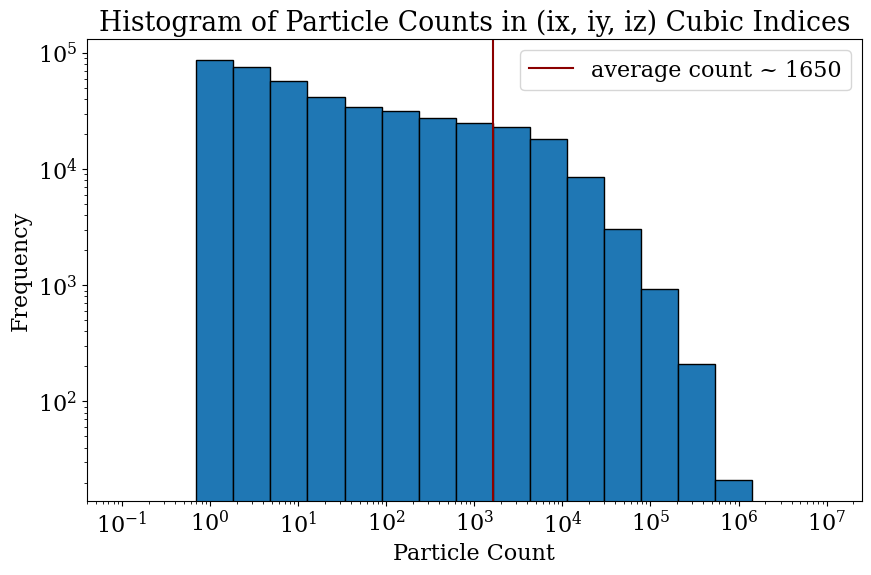

In [15]:
plt.figure(figsize=(10,6))
plt.hist(pandas_counts_df['particle_count'], bins=np.logspace(-1, 7, 20), edgecolor='black')
plt.axvline(x=np.average(pandas_counts_df['particle_count']), color = 'darkred',label = 'average count ~ 1650')
plt.title("Histogram of Particle Counts in (ix, iy, iz) Cubic Indices")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Particle Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [7]:
%%time
#subhalo table
#subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim.parquet.snappy'
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim_cubic_indexed.parquet.snappy'
subdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)

#adding a column for the subhalo id
#subdf = subdf.withColumn("sub_id", F.monotonically_increasing_id())
#windowSpec = W.orderBy("sub_id")
#subdf = subdf.withColumn("sub_id", F.row_number().over(windowSpec) - 1)

subdf.limit(4).toPandas()
#subdf.describe().toPandas().T 

CPU times: user 5.92 ms, sys: 6.21 ms, total: 12.1 ms
Wall time: 721 ms


,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_mass,sub_id,sub_ix,sub_iy,sub_iz
0,39401.218750,43350.691406,150814.250000,343.093842,1247.922363,-420.458649,2.724841e+10,67875,19,21,73
1,35301.429688,136290.875000,171013.640625,706.050110,177.015137,-33.084732,2.605518e+10,67876,17,66,83
2,55238.164062,64904.765625,12711.584961,-205.236481,-150.627762,-276.507416,3.077018e+10,67877,26,31,6
3,184922.171875,4709.947754,151160.218750,25.438437,-17.173027,-139.466187,2.627657e+10,67878,90,2,73


In [18]:
##changing the column name for cross joining
#subdf = subdf.withColumnRenamed("px", "sub_px")
#subdf = subdf.withColumnRenamed("py", "sub_py")
#subdf = subdf.withColumnRenamed("pz", "sub_pz")
#subdf = subdf.withColumnRenamed("vx", "sub_vx")
#subdf = subdf.withColumnRenamed("vy", "sub_vy")
#subdf = subdf.withColumnRenamed("vz", "sub_vz")
#subdf = subdf.withColumnRenamed("mass", "sub_mass")

##dividing the data into 100*100*100 boxes and adding the column for the box id
#subdf = subdf.withColumn("sub_ix", floor(F.col("sub_px") / (box_size/100)).cast('int'))
#subdf = subdf.withColumn("sub_iy", floor(F.col("sub_py") / (box_size/100)).cast('int'))
#subdf = subdf.withColumn("sub_iz", floor(F.col("sub_pz") / (box_size/100)).cast('int'))
#
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim_cubic_indexed.parquet.snappy'
#subdf.write.option("compression", "snappy").mode("overwrite").save(outname)
#subdf.toPandas().head()

,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_mass,sub_id,sub_ix,sub_iy,sub_iz
0,99173.578125,40274.546875,107897.390625,-67.104362,-151.330200,167.907593,3.492153e+11,103713,48,19,52
1,120705.281250,69941.101562,157908.031250,269.752045,-320.683807,128.344238,3.287442e+11,103714,58,34,77
2,204545.296875,170294.812500,87957.867188,363.489685,148.479889,-54.548824,3.453248e+11,103715,99,83,42
3,173194.890625,158155.453125,162955.359375,83.774239,-126.974121,218.970139,3.937560e+11,103716,84,77,79
4,34154.796875,35974.179688,149377.250000,559.149902,597.246765,-471.297150,3.869574e+11,103717,16,17,72


# 2. Saving the particle data within the 50kpc spheres centered at each subhalo

In [ ]:
#direct distance square calculation
radius_sq = (50*h)**2 #50kpc aperture size
id_size = 100 #number of boxes

#broad casting the subhalo table to the all workers
broadcast_subdf = F.broadcast(subdf)

# Step 1: Coarse filtering by grid indices considering the periodic boundary
filtered_df = rawdf.crossJoin(broadcast_subdf).filter(
    (F.least(F.abs(F.col("ix") - F.col("sub_ix")), id_size - F.abs(F.col("ix") - F.col("sub_ix")) ) <= 1) &
    (F.least(F.abs(F.col("iy") - F.col("sub_iy")), id_size - F.abs(F.col("iy") - F.col("sub_iy")) ) <= 1) &
    (F.least(F.abs(F.col("iz") - F.col("sub_iz")), id_size - F.abs(F.col("iz") - F.col("sub_iz")) ) <= 1)

filtered_df = filtered_df.withColumn("dist_cent_sq", F.pow(F.least(F.abs(F.col("px") - F.col("sub_px")), box_size - F.abs(F.col("px") - F.col("sub_px"))), 2) +
                                                     F.pow(F.least(F.abs(F.col("py") - F.col("sub_py")), box_size - F.abs(F.col("py") - F.col("sub_py"))), 2) +
                                                     F.pow(F.least(F.abs(F.col("pz") - F.col("sub_pz")), box_size - F.abs(F.col("pz") - F.col("sub_pz"))), 2))

# Step 2: Fine filtering by distance calculation considering the periodic boundary
filtered_df = filtered_df.filter(
    (F.col("dist_cent_sq")) < radius_sq
)

# Select relevant columns (including subhalo_id for identification)
result_df = filtered_df.select("sub_id", "px", "py", "pz", "vx", "vy", "vz", "mass", "dist_cent_sq")

subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'
result_df.write.option("compression", "snappy").mode("overwrite").partitionBy("sub_id").parquet(subname)

# 2-1. KDTree Algorithm

In [30]:
#unique subbox id pairs
# Step 1: Select the relevant columns and get distinct values
unique_ids_df = subdf.select("sub_ix", "sub_iy", "sub_iz").distinct()

# Step 2: Collect the results to get a list of unique (id_x, id_y, id_z) tuples
unique_ids_list = unique_ids_df.rdd.map(tuple).collect()
print(len(unique_ids_list))

39161


In [42]:
%%time
#kd-tree algorithm

radius_kpc = 50 * h  # 50 kpc aperture size
id_size = 100 #number of boxes

#for the subbox id pair (ix, iy, iz)
id_pair = unique_ids_list[0]
subbox_size = box_size / id_size

#center position of the subbox
box_cent = np.array(id_pair) * subbox_size + np.array([1,1,1]) * subbox_size/2

#rough filtering using subbox id
filtered_ptl_df = rawdf.filter(
    (F.least(F.abs(F.col("ix") - id_pair[0]), id_size - F.abs(F.col("ix") - id_pair[0]) ) <= 1) &
    (F.least(F.abs(F.col("iy") - id_pair[1]), id_size - F.abs(F.col("iy") - id_pair[1]) ) <= 1) &
    (F.least(F.abs(F.col("iz") - id_pair[2]), id_size - F.abs(F.col("iz") - id_pair[2]) ) <= 1))

filtered_sub_df = subdf.filter(
    (F.least(F.abs(F.col("sub_ix") - id_pair[0]), id_size - F.abs(F.col("sub_ix") - id_pair[0]) ) <= 1) &
    (F.least(F.abs(F.col("sub_iy") - id_pair[1]), id_size - F.abs(F.col("sub_iy") - id_pair[1]) ) <= 1) &
    (F.least(F.abs(F.col("sub_iz") - id_pair[2]), id_size - F.abs(F.col("sub_iz") - id_pair[2]) ) <= 1))

#relative coordinate from the subbox center (box_cent). Considering the periodic boundary
filtered_ptl_df = filtered_ptl_df.withColumn(
    "px_box_cent",
    F.pmod((F.col("px") - box_cent[0]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "py_box_cent",
    F.pmod((F.col("py") - box_cent[1]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "pz_box_cent",
    F.pmod((F.col("pz") - box_cent[2]) + box_size / 2, box_size) - box_size / 2
)

filtered_sub_df = filtered_sub_df.withColumn(
    "sub_px_box_cent",
    F.pmod((F.col("sub_px") - box_cent[0]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "sub_py_box_cent",
    F.pmod((F.col("sub_py") - box_cent[1]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "sub_pz_box_cent",
    F.pmod((F.col("sub_pz") - box_cent[2]) + box_size / 2, box_size) - box_size / 2
)

# Step 1: Convert PySpark DataFrames to Pandas
particle_df_pd = filtered_ptl_df.select("px", "py", "pz", "vx", "vy", "vz", "mass", "px_box_cent", "py_box_cent", "pz_box_cent").toPandas()
subhalo_df_pd = filtered_sub_df.select("sub_id", "sub_px_box_cent", "sub_py_box_cent", "sub_pz_box_cent").toPandas()

# Step 2: Build cKDTree with Particle Positions
particle_positions = particle_df_pd[["px_box_cent", "py_box_cent", "pz_box_cent"]].values
ckdtree = cKDTree(particle_positions)  # Use cKDTree

subhalo_positions = subhalo_df_pd[["sub_px_box_cent", "sub_py_box_cent", "sub_pz_box_cent"]].values
indices = ckdtree.query_ball_point(subhalo_positions, r=radius_kpc)

#saving the relevant data
filtered_particles = []
for sub_idx, particle_idx_list in enumerate(indices):
    if particle_idx_list:
        # For each subhalo, find the corresponding particles and save relevant data
        subhalo = subhalo_df_pd.iloc[sub_idx]
        subhalo_pos = subhalo[["sub_px_box_cent", "sub_py_box_cent", "sub_pz_box_cent"]].values
        
        for particle_idx in particle_idx_list:
            particle = particle_df_pd.iloc[particle_idx]
            particle_pos = particle[["px_box_cent", "py_box_cent", "pz_box_cent"]].values
            
            # Calculate squared distance (dist_cent_sq) between particle and subhalo
            dist_cent_sq = np.sum((particle_pos - subhalo_pos) ** 2)
            
            # Save the particle and subhalo data along with the squared distance
            filtered_particles.append({
                'sub_id': subhalo['sub_id'],
                'px': particle['px'],
                'py': particle['py'],
                'pz': particle['pz'],
                'vx': particle['vx'],
                'vy': particle['vy'],
                'vz': particle['vz'],
                'mass': particle['mass'],
                'dist_cent_sq': dist_cent_sq  # Include the squared distance
            })

# Step 5: Convert filtered particles to Pandas DataFrame and back to PySpark
filtered_df_pd = pd.DataFrame(filtered_particles)
filtered_df = spark.createDataFrame(filtered_df_pd)

# Step 6: Save the results with partitioning by sub_id
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_241002_kdtree_particles.parquet.snappy'
filtered_df.write.option("compression", "snappy").mode("overwrite").partitionBy("sub_id").parquet(subname)

/usr/local/spark/python/pyspark/sql/pandas/serializers.py:229: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(s.dtype):


CPU times: user 23.9 s, sys: 452 ms, total: 24.4 s
Wall time: 1min 6s


In [7]:
#Checking the data
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'
df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 10000)
df_filtered.describe().toPandas()

,summary,px,py,pz,vx,vy,vz,mass,dist_cent_sq,sub_id
0,count,160,160,160,160,160,160,160,160,160
1,mean,86539.98217092815,115001.8123021865,144899.63376864442,-173.17213001875004,-162.7695493062501,201.53382877500002,5.594609641875001E-4,52.507032744363826,10000.0
2,stddev,4.3586223280873195,3.330779277000689,4.676035647780895,39.405089898886125,39.32917348856376,38.71986463333312,1.4510780084495814E-4,133.96340006846228,0.0
3,min,86517.54089495828,114987.06916561146,144874.48056289784,-298.88245,-250.64078,100.80679,2.5858832E-4,0.3857580077748698,10000
4,max,86558.38979516154,115009.8895705654,144911.07695180256,-54.3939,-47.9957,280.2506,8.7464123E-4,1050.5479423833408,10000


# 3. Calculating stellar velocity dispersion

We measure the stellar velocity dispersion of ~10$^5$ subhalos. We first select stellar particles within subhalo-centered spheres with a certain radius. We then calculate the mass-weighted stellar velocity dispersion based on the 3D velocity of selected stellar particles. 

### $M = \Sigma m_i $
### $\overline{v_x} = \frac{\Sigma m_i v_{i,x}}{M}$, $\, \overline{v_y} = \frac{\Sigma m_i v_{i,y}}{M}$, $\, \overline{v_z} = \frac{\Sigma m_i v_{i,z}}{M}$ 
### $\sigma_x^2 = \frac{\Sigma m_i (v_{i,x} - \overline{v_{x}})^2}{M}$, $\, \sigma_y^2 = \frac{\Sigma m_i (v_{i,y} - \overline{v_{y}})^2}{M}$, $\, \sigma_z^2 = \frac{\Sigma m_i (v_{i,z} - \overline{v_{z}})^2}{M}$
### $\therefore \sigma_{3D} = \sqrt{\sigma_x^2 + \sigma_y^2 + \sigma_z^2}$
We repeat the above calculation for six different radii (3, 5, 10, 20, 30, and 50 kpc).

In [4]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'

df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 0)
df_filtered.describe().toPandas()

24/09/30 14:51:30 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 524288000 bytes). This may impact query planning performance.


,summary,px,py,pz,vx,vy,vz,mass,dist_cent_sq,sub_id
0,count,140,140,140,140,140,140,140,140,140
1,mean,41840.652056403436,49050.240491958146,146618.59384127078,491.1804762142857,2141.1263542857128,-734.4352684999993,5.289361012142856E-4,33.778025427646135,0.0
2,stddev,3.434179745897391,2.646253888959987,3.8308437191442546,47.42457028605087,43.16277394559926,46.21973330251511,1.3347494347952017E-4,69.45086123003283,0.0
3,min,41821.05056670708,49042.46942823968,146605.40289966715,330.69318,2015.9958,-865.76483,2.9745823E-4,2.034020586918334E-7,0
4,max,41854.11205584526,49061.58165936835,146634.89777236278,636.5443,2252.1292,-622.19794,8.7916595E-4,445.53822808873207,0


In [5]:
subhalo_count = df.select("sub_id").distinct().count()
print(f"Number of distinct subhalo IDs: {subhalo_count}")

Number of distinct subhalo IDs: 104290


In [5]:
%%time
from pyspark.sql import Window as W
import pyspark.sql.functions as F

# Define subhalo window for partitioning by "sub_id"
subhalo_window = W.partitionBy("sub_id")

# Initial weighted velocity and dispersion calculations for all particles
df = df.withColumn("vx_weighted", F.col("mass") * F.col("vx"))
df = df.withColumn("vy_weighted", F.col("mass") * F.col("vy"))
df = df.withColumn("vz_weighted", F.col("mass") * F.col("vz"))

df = df.withColumn("mass_sum", F.sum("mass").over(subhalo_window))

df = df.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))

df = df.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
df = df.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
df = df.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)

df = df.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

# First aperture (50 kpc)
velocity_dispersion_df = df.groupBy("sub_id").agg(
    (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_50")
)

# Iterate through different apertures (30, 20, 10, 5, 3 kpc)
for apert in [30, 20, 10, 5, 3]:
    # Reset the DataFrame for each aperture
    distance_limit = (apert * h) ** 2
    df_aperture = df.filter(F.col("dist_cent_sq") <= distance_limit)

    df_aperture = df_aperture.withColumn("mass_sum", F.sum("mass").over(subhalo_window))
    
    df_aperture = df_aperture.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))
    
    df_aperture = df_aperture.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
    df_aperture = df_aperture.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
    df_aperture = df_aperture.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)
    
    df_aperture = df_aperture.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

    velocity_dispersion_tmp = df_aperture.groupBy("sub_id").agg(
        (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_" + str(apert))
    )
    
    # Combine the results for each aperture
    velocity_dispersion_df = velocity_dispersion_df.join(velocity_dispersion_tmp, "sub_id")

# Show the final combined DataFrame
velocity_dispersion_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|   148|                   60.35325051104237|                   61.38776748254439|                   62.38146856184683|                   65.64963521122424|                  70.08732553224418|                   68.7290238298842|
|   463|                  350.06665387531825|                   174.3795225514606|  

In [8]:
sub_id_to_find = 10000
filtered_df = velocity_dispersion_df.filter(velocity_dispersion_df["sub_id"] == sub_id_to_find)
filtered_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
| 10000|                   67.54407056722899|                   67.25768361639068|                   67.79019897412951|                   68.88366311763865|                  72.93970174994601|                  73.40487757132327|
+------+------------------------------------+------------------------------------+--

In [9]:
%%time
#calculating in divided data 
file_num = [0, 1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 104290]
#for i in range(10):
for i in [0]:
    subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/vdisp_240918_'+str(int(file_num[i]))+'_snappy.parquet'
    filtered_df = velocity_dispersion_df.filter((velocity_dispersion_df["sub_id"] > file_num[i]) &
                                                (velocity_dispersion_df["sub_id"] < file_num[i+1])
                                               )
    filtered_df.write.mode("overwrite").parquet(subname, compression="snappy")

24/09/27 13:10:26 WARN TaskSetManager: Lost task 138.0 in stage 76.1 (TID 107912) (192.168.0.139 executor 21): TaskKilled (Stage cancelled)
24/09/27 13:10:26 WARN TaskSetManager: Lost task 144.0 in stage 76.1 (TID 107918) (192.168.0.139 executor 21): TaskKilled (Stage cancelled)
24/09/27 13:10:26 WARN TaskSetManager: Lost task 158.0 in stage 76.1 (TID 107930) (192.168.0.139 executor 21): TaskKilled (Stage cancelled)
24/09/27 13:10:26 WARN TaskSetManager: Lost task 135.0 in stage 76.1 (TID 107909) (192.168.0.139 executor 21): TaskKilled (Stage cancelled)
24/09/27 13:10:26 WARN TaskSetManager: Lost task 132.0 in stage 76.1 (TID 107906) (192.168.0.139 executor 21): TaskKilled (Stage cancelled)
24/09/27 13:10:26 WARN TaskSetManager: Lost task 161.0 in stage 76.1 (TID 107933) (192.168.0.139 executor 21): TaskKilled (Stage cancelled)
24/09/27 13:10:26 WARN TaskSetManager: Lost task 164.0 in stage 76.1 (TID 107936) (192.168.0.139 executor 21): TaskKilled (Stage cancelled)
24/09/27 13:10:26 WA

CPU times: user 47.4 ms, sys: 3.98 ms, total: 51.4 ms
Wall time: 12.2 s


In [13]:
i*3000

57000

In [18]:
df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 58500)
df_filtered.describe().toPandas()

#subhalo_count = df.select("sub_id").distinct().count()
#print(f"Number of distinct subhalo IDs: {subhalo_count}")

,summary,sub_id,mass_weighted_velocity_dispersion_50,mass_weighted_velocity_dispersion_30,mass_weighted_velocity_dispersion_20,mass_weighted_velocity_dispersion_10,mass_weighted_velocity_dispersion_5,mass_weighted_velocity_dispersion_3
0,count,1,1,1,1,1,1,1
1,mean,58500.0,275.02324402398716,188.40888982038877,159.38834687070212,145.80983235813972,144.4308254868995,140.31133703063
2,stddev,None,None,None,None,None,None,None
3,min,58500,275.02324402398716,188.40888982038877,159.38834687070212,145.80983235813972,144.4308254868995,140.31133703063
4,max,58500,275.02324402398716,188.40888982038877,159.38834687070212,145.80983235813972,144.4308254868995,140.31133703063
